In [1]:
from sbhandler import *
import pickle

In [2]:
# load_matlab_file function Testing
file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

# DNA_seqs can be used to grab each raw_seqblock
DNA_seqs = DNA_SeqBlocks(h5py_object=h5py_object, data=data) 

FILE_SIZE = DNA_seqs.size #Constant

In [3]:
# Load in barcodes and truelens for the day
df = pickle.load(open('pickle/v2BarcodesTruelen.pickle', 'rb'))
BARCODES = df.barcode
TRUELENS = df.true_len

In [4]:
# Make sure it works on a small dataset first.
tinyDS = range(1, 10001)
DS = range(1, FILE_SIZE+1)

In [5]:
# Load 'em in 
bfp_list = pickle.load( open('pickle/raw_bfp.pickle', 'rb'))
rfp_list = pickle.load( open('pickle/raw_rfp.pickle', 'rb'))

In [6]:
def is_deletion(df, idx, rfp=False):
    if rfp:
        if df['contig'].iloc[idx] != 45: return True
        return False
    if df['target'].iloc[idx] != 45: return True
    return False

def is_concord_del(df, idx, read_len, rfp=False):
    if idx + 1 == read_len or idx == 0: return False
    if rfp:
        if df['contig'].iloc[idx+1] == df['contig'].iloc[idx-1]: return True
        return False
    if df['target'].iloc[idx+1] == df['target'].iloc[idx-1]: return True
    return False
    
def is_single_insert(df, idx, read_len, rfp=False):
    if idx + 1 == read_len or idx == 0: return False
    if rfp:
        if df['contig'].iloc[idx+1] != 45 and df['contig'].iloc[idx-1] != 45: return True
        return False
    if df['target'].iloc[idx+1] != 45 and df['target'].iloc[idx-1] != 45: return True
    return False
    
def is_concord_insert(read, idx):
    sandwich = nuc_sandwich(read, idx)
    if sandwich[0] == sandwich[1]: return True
    return False


In [7]:
# Functions made for 'Sequencing Error Rates' block
def truncate_start(read):
    idx = 0
    if len(read) > 2 and read.iloc[0] == 45: # if it starts with an indel
        idx = 1
        while (idx < len(read) and read.iloc[idx] == 45):
            # if (idx > 0 and idx % 100 == 0): print(bfp.index.name)\
            idx += 1
    return idx

def truncate_end(read, idx):
    len_read = len(read)
    end = len_read
    if len_read < 4: return end # Surprisingly this was needed.
    if (read[-3:] == [45, 45, 45]).all():
        end = len_read - 3
        while idx < (end) and read.iloc[end] == 45: # POTENTIAL BUG: Trying while idx < end, instead of idx < end - 1
            end -= 1
    return end

def nuc_sandwich(read, idx):
    if len(read) > idx + 1 and idx > 0:
        left = read.iloc[idx-1]
        right = read.iloc[idx+1]
        lidx = idx-2
        ridx = idx+2
        while lidx >= 0 and left == 45:
            left = read.iloc[lidx]
            lidx -= 1
        while ridx + 1 < len(read) and right == 45:
            right = read.iloc[ridx]
            ridx += 1
        left = chr(left)
        right = chr(right)
        return str(left+right)
    print(read, idx)
    return 'None'

def idx_del(read, idx):
    # initialize
    left = read.iloc[idx]
    right = read.iloc[idx]
    lidx = idx
    ridx = idx
    
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = read.iloc[lidx]
    while ridx + 1 < len(read) and right == 45:
        right = read.iloc[ridx]
        ridx += 1
    return lidx+1, ridx-1 # gives the exact .iloc[] of where the deletions are

def idx_ins(df, idx, rfp=False): #same inner mechanics as idx_del but uses target to find 
    if rfp:
        return idx_del(df['contig'], idx)
    return idx_del(df['target'], idx)

def get_trunc_range(read):
    idx = truncate_start(read)
    end = truncate_end(read, idx)
    return range(idx, end)
    
def get_cov(df): return int((len(df.columns)-4)/2)

def get_yBlock(df, read, idx, rfp=False): pass

def isFalseInDel(df, read, idx, rfp=False, conditional = False): # Done. Checks target and read to see if they are both indels
    if conditional:
        if df.iloc[idx] == 45 and read.iloc[idx] == 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] == 45 and read.iloc[idx] == 45: return True
        return False
    if df['target'].iloc[idx] == 45 and read.iloc[idx] == 45: return True
    return False
# Which major yyy conflict?
def isDel(df, read, idx, rfp=False, conditional=False): # Checks if targ doesn't have an indel where the read has one.
    if conditional:
        if df.iloc[idx] != 45 and read.iloc[idx] == 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] != 45 and read.iloc[idx] == 45: return True
        return False
    if df['target'].iloc[idx] != 45 and read.iloc[idx] == 45: return True
    return False

def isIns(df, read, idx, rfp=False, conditional=False): # Checks if targ has an indel where a read has a NUC.
    print('Use isDel')
    if conditional:
        if df.iloc[idx] == 45 and read.iloc[idx] != 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx] == 45 and read.iloc[idx] != 45: return True
        return False
    if df['target'].iloc[idx] == 45 and read.iloc[idx] != 45: return True
    return False
# Single or Multi?
def isSingleDel(read, idx): # Checks if read has only one indel.
    if read.iloc[idx+1] != 45 and read.iloc[idx-1] != 45: return True
    return False

def isSingleIns(df, idx, rfp=False, conditional=False): # Checks if target has only one indel.
    if conditional:
        if df.iloc[idx+1] != 45 and df.iloc[idx-1] != 45: return True
        return False
    
    if rfp:
        if df['contig'].iloc[idx+1] != 45 and df['contig'].iloc[idx-1] != 45: return True
        return False
    if df['target'].iloc[idx+1] != 45 and df['target'].iloc[idx-1] != 45: return True
    return False
# How big is the Multi? (False^)
def countDel(read, idx): # Retruns the count of dels in a multiple deletion
    count = 1
    left = read.iloc[idx-1]
    right = read.iloc[idx+1]
    lidx = idx
    ridx = idx
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = read.iloc[lidx]
        if left == 45: count += 1
    while ridx + 1 < len(read) and right == 45:
        ridx += 1
        right = read.iloc[ridx]
        if right == 45: count += 1
    return count

def countIns(targ, idx): # Returns the count of ins in a multi ins.
    count = 1
    left = targ.iloc[idx-1]
    right = targ.iloc[idx+1]
    lidx = idx
    ridx = idx
    while lidx >= 0 and left == 45:
        lidx -= 1
        left = targ.iloc[lidx]
        if left == 45: count += 1
    while ridx + 1 < len(targ) and right == 45:
        ridx += 1
        right = targ.iloc[ridx]
        if right == 45: count += 1
    return count


## GET: Separate BFP and RFP into pd.DataFrame objects. 

In [ ]:
# bfp_list = []
# rfp_list = []

# for i in DS:
#     end = TRUELENS[i]
#     b, r = DNA_seqs.get_br(i, end)
#     bfp_list.append(b)
#     rfp_list.append(r)

In [6]:
# with open('pickle/raw_bfp.pickle', 'wb') as f:
#     pickle.dump(bfp_list, f)

# with open('pickle/raw_rfp.pickle', 'wb') as f:
#     pickle.dump(rfp_list, f)

### Support of Nucleotides (RFP and BFP)

[0.27, 0.30, 0.27, 0.16, 0.00] BFP

[0.23, 0.32, 0.31, 0.15, 0.00] RFP

In [ ]:
bfp_targ_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))
bfp_read_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))

for n, bfp in enumerate(bfp_list):
    if n % 3550 == 0: print(f'{100*(n/355104):.0f}%')
    if bfp.empty: continue
    
    targ = bfp['target']
    idx = 0
    if len(targ) > 2 and targ.iloc[0] == 45: # if it starts with an indel
        idx = 1
        while (targ.iloc[idx] == 45) and idx < len(targ):
            idx += 1
    for num in range(idx, len(targ)):
        bfp_targ_counter[chr(targ.iloc[num])] += 1
    cov = int( (len(bfp.columns) -4 )/2)
    for r in range(cov):
        read = bfp[f'read{r+1}']
        idx = 0
        if len(read) > 2 and read.iloc[0] == 45: # if it starts with an indel
            # print(len(read))
            idx = 1
            while (idx < len(read) and read.iloc[idx] == 45):
                # if (idx > 0 and idx % 100 == 0): print(bfp.index.name)
    
                idx += 1
        for num in range(idx, len(read)):
            bfp_read_counter[chr(read.iloc[num])] += 1


total_btc = sum(bfp_targ_counter.values())            
for nuc, val in bfp_targ_counter.items():
    print(f'{nuc}: {val/total_btc:.2f}')
    print('\n')
total_brc = sum(bfp_read_counter.values())
for nuc, val in bfp_read_counter.items():
    print(f'{nuc}: {val/total_brc:.2f}')


In [ ]:
rfp_targ_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))
rfp_read_counter = dict(zip(['A', 'C', 'G', 'T', '-'], [0]*5))

for n, rfp in enumerate(rfp_list[0::50]):
    # print(n*50)
    if n % 3550 == 0: print(f'{n/355104:.2f}%')
    if rfp.empty: continue
    
    cov = int( (len(rfp.columns) -4 )/2)
    if cov > 3: 
        targ = rfp['contig']
        idx = 0
        len_targ = len(targ)
        if len(targ) > 1 and targ.iloc[0] == 45: # if it starts with an indel
            idx = 1
            while ( idx < len_targ and targ.iloc[idx] == 45):
                idx += 1
        for num in range(idx, len_targ):
            rfp_targ_counter[chr(targ.iloc[num])] += 1
    
    for r in range(cov):
        read = rfp[f'read{r+1}']
        idx = 0
        len_read = len(read)
        if len_read > 2 and read.iloc[0] == 45: # if it starts with an indel
            # print(len(read))
            idx = 1
            while (idx < len_read and read.iloc[idx] == 45):
                # if (idx > 0 and idx % 100 == 0): print(rfp.index.name)
    
                idx += 1
        end = len_read
        if (read[-3:] == [45, 45, 45]).all():
            end = len_read - 4
            while idx < (end - 1) and read.iloc[end] == 45:
                end = end - 1
            
        for num in range(idx, end): 
            rfp_read_counter[chr(read.iloc[num])] += 1

total_rtc = sum(rfp_targ_counter.values())            
for nuc, val in rfp_targ_counter.items():
    print(f'{nuc}: {val/total_rtc:.2f}')
print('\n')
total_rrc = sum(rfp_read_counter.values())
for nuc, val in rfp_read_counter.items():
    print(f'{nuc}: {val/total_rrc:.2f}')

#### EXPLORE: Which Q score random variable (mapping function) produces the most linear relationship between Phred Q scores and inaccuracies?

In [8]:
def get_lr(df, read, idx, cov):
    if idx +1 < len(read) and idx > 0:
        if cov < 10: the_number = read.name[-1]
        else: 
            try: the_number = int(read.name[-2:])
            except: the_number = read.name[-1]
            
        left = df[f'q{the_number}'].iloc[idx-1]
        right = df[f'q{the_number}'].iloc[idx+1]
        lidx = idx-2
        ridx = idx+2
        while lidx >= 0 and left == 33:
            left = df[f'q{the_number}'].iloc[lidx]
            lidx -= 1
        while ridx + 1 < len(read) and right == 33:
            right = df[f'q{the_number}'].iloc[ridx]
            ridx += 1
        return left, right    
    return -1, -1

def use_inverse_sum(df, read, idx, cov):
    left, right = get_lr(df, read, idx, cov)
    if left != -1:
        return int(2*((1)/((1/left)+(1/right))))
    else: 
        return 33
    
def use_min(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.min([l, r])
    return 33

def use_max(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.max([l, r])
    return 33

def use_geo_mean(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.sqrt(l*r)
    return 33

def use_arith_mean(df, read, idx, cov):
    l, r = get_lr(df, read, idx, cov)
    if l != -1: return np.mean([l, r])
    return 33

def each_read(original_df, cov):
    """Returns list of all reads for a df

    Args:
        original_df (_type_): _description_

    Returns:
        _type_: _description_
    """
    each_read = []
    for read_num in range(1, cov+1):
        each_read.append(original_df[f'read{read_num}'])
    return each_read

def list_read(original_df, cov):
    return [f'read{read_num}' for read_num in range(1, cov+1)]
    

### Test diffferent Indel QScore Mapping Functions

Obtain the frequency of correct vs error

In [105]:
snips = {'A' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'C' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'G' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'T' : {i : [0,0,0,0,0] for i in np.arange(33,127)}}
            
indels = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}

def hot_encode(num):
    if num == 65: return 1
    elif num == 67: return 2
    elif num == 71: return 3
    elif num == 84: return 4
    else: return 5

# If idx = 0 does not equal correct
def raw_hot_encode(num):
    if num == 65: return 0
    elif num == 67: return 1
    elif num == 71: return 2
    elif num == 84: return 3
    else: return 4

In [ ]:
import copy
QSCORE_FUNCS_TO_TEST = [use_inverse_sum, use_min, use_max, use_geo_mean, use_arith_mean]
# each_qscore = {'correct' : 0, 'A' : 0, 'C' : 0, 'G' : 0, 'T' : 0, '-' : 0}

# deletions = { 'A' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'C' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'G' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'T' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) }}

t = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}
        

qscore_test = [copy.deepcopy(t), copy.deepcopy(t), copy.deepcopy(t), copy.deepcopy(t), copy.deepcopy(t)]

# conditional_error = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  

# For idx = 0 equals correct
    
for n, bfp in enumerate(bfp_list):
    if n % 3500 == 0: print(f'{n/350000:.0%}')
    if bfp.empty: continue
    
    cov = get_cov(bfp)
    
    for read_num in range(1, cov+1): # for each read
        read = bfp[f'read{read_num}']
        idx = truncate_start(read)
        end = truncate_end(read, idx)
        
        for nuc in range(idx, end):
            
            true_nuc = bfp.iloc[nuc,0]
            chr_tnuc = chr(true_nuc) # convert to a chr the targ
            
            qscore = bfp[f'q{read_num}'].iloc[nuc] # The qscore
            check = read.iloc[nuc]
            
            if qscore == 33: # An indel is present... What should it's actual qscore be? Depends on insertion or deletion
                
                # -----------------
                # QSCORE TESTING
                # ------------------
                
                for i, func in enumerate(QSCORE_FUNCS_TO_TEST):
                    qscore = int(func(bfp, read, nuc, cov))
                    
                    if check == true_nuc:
                        qscore_test[i][chr_tnuc][qscore][0] += 1
                    else:
                        qscore_test[i][chr_tnuc][qscore][hot_encode(check)] += 1
                continue
            
            else:       
                if check == true_nuc: 
                    for i in range(5):
                    # If correct. Add to observed
                    # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                    # tracking[chr_tnuc][qscore]['correct'] += 1
                        qscore_test[i][chr_tnuc][qscore][0] += 1
                else: # If they disagree
                    # conditional_error[chr_tnuc][raw_hot_encode(check)] += 1
                    for i in range(5):
                        qscore_test[i][chr_tnuc][qscore][hot_encode(check)] +=1        

In [ ]:
import pickle
with open('pickle/qscore_func.pickle', 'wb') as f:
    pickle.dump(qscore_test, f)

Now, include high-coverage RFP to increase sample density

In [ ]:
#78 minutes
conditional_error_red = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))
# deletions_red = { 'A' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'C' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'G' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) },
#               'T' : {i : dict(zip(['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT'],[0]*16)) for i in np.arange(32, 127) }}

shuffled = np.random.permutation( len(rfp_list))

count = 0
for n, shuffle in enumerate(shuffled):
    rfp = rfp_list[shuffle]
    if (n% 3500 == 0): print(f'{n/350000:.0%}')
    
    if (count > 30000): break
    
    if rfp.empty: continue
    
    cov = int((len(rfp.columns)-4)/2)
    if cov > 4:
        count += 1
        for read_num in range(1, cov+1):
            read = rfp[f'read{read_num}']
            true = rfp.loc[:, 'contig']
            idx = truncate_start(read)
            end = truncate_end(read, idx)
            
            q = rfp[f'q{read_num}']
            
            for nuc in range(idx, end):
                true_nuc = true.iloc[nuc]
                chr_tnuc = chr(true_nuc) # convert to a chr the targ

                qscore = q.iloc[nuc] # The qscore
                check = read.iloc[nuc] # 
                
                if qscore == 33: # An indel is present... What should it's actual qscore be? Depends on insertion or deletion
                
                # -----------------
                # QSCORE TESTING
                # ------------------
                    for i, func in enumerate(QSCORE_FUNCS_TO_TEST):
                        qscore = int(func(bfp, read, nuc, cov))
                        
                        if check == true_nuc:
                            qscore_test[i][chr_tnuc][qscore][0] += 1
                        else:
                            qscore_test[i][chr_tnuc][qscore][hot_encode(check)] += 1
                    continue
                
                else:       
                    if check == true_nuc: 
                        for i in range(5):
                        # If correct. Add to observed
                        # tracking[chr_tnuc][qscore] = tracking[chr_tnuc].setdefault(qscore, {'correct' : 0,65:0,67:0,71:0,84:0,45:0})
                        # tracking[chr_tnuc][qscore]['correct'] += 1
                            qscore_test[i][chr_tnuc][qscore][0] += 1
                    else: # If they disagree
                        # conditional_error[chr_tnuc][raw_hot_encode(check)] += 1
                        # conditional_error_red[chr_tnuc][raw_hot_encode(check)] += 1
                        for i in range(5):
                            qscore_test[i][chr_tnuc][qscore][hot_encode(check)] +=1     
            

In [ ]:
with open( 'pickle/qscore_func_wRFP.pickle', 'wb') as f:
    pickle.dump(qscore_test, f)

### Conditional Sequencing Error Matrix
- 5x5 matrix.
- Indels mapped to a Q score by MIN of neighbors.

In [170]:
def update_counter(tracking, reads, df, idx, rfp=False):
    if rfp:
        true_nuc = df['contig'].iloc[idx]
    else:
        true_nuc = df['target'].iloc[idx]
    chr_tnuc = chr(true_nuc)
    
    for r in reads:
        check = r.iloc[idx]
        if check == 1: continue # The placeholder I used for meaningless alignments (not an indel)
        if check == true_nuc: continue
        tracking[chr_tnuc][raw_hot_encode(check)] += 1
               

# NEXT Thing to Run

In [135]:

#  Confirm if use_min works for both single and multi indels? 

# Disregards quality score. Simply frequency.
cond_err = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  

# Disregards quality score. Separates snps and indels
cond_err_snps = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  
cond_err_indels = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  


In [136]:

# //TODO: EXECUTE: Run this block before leaving tomorrow.
# Includes quality score. All SNPs, indels
t = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
     'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
     'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
     'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
     '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}

# Includes quality score. Only single indels.
# //FIXME: Add a column to bfp_list and rfp_list. isSingleIndel.
single_indels = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
    '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}


In [ ]:
for n, bfp in enumerate(bfp_list):
    if (n % 3500 == 0): print(f'{n/350_000:.0%}')
    if bfp.empty: continue
    targ = bfp['target']
    COV = get_cov(bfp)
    reads = each_read(bfp, COV)
    isIndel = bfp['is_indel']
    for idx in range(len(bfp)):
        update_counter(cond_err, reads, bfp, idx)
        if isIndel.iloc[idx] == True:
            # update_tracker(indels, reads, bfp, idx, COV)
            update_counter(cond_err_indels, reads, bfp, idx)
        else: #SNP
            # update_tracker(snips, reads, bfp, idx, COV)     
            update_counter(cond_err_snps, reads, bfp, idx)


In [138]:
import pickle
with open('pickle/cond_error_bfp.pickle', 'wb') as f:
    pickle.dump(cond_err, f)
with open('pickle/cond_err_snps_bfp.pickle', 'wb') as f:
    pickle.dump(cond_err_snps, f)
with open('pickle/cond_err_indels_bfp.pickle', 'wb') as f:
    pickle.dump(cond_err_indels, f)

In [198]:
def show_cmtx(df, drop=False):
    df/= np.sum(df, axis=0)
    df.index = ['A', 'C', 'G', 'T', '-']
    if drop:
        df = df.drop('-', axis=1).drop('-')
    print(df.head())
    return df
    

allbfp = pd.DataFrame(cond_err)
show_cond_mtx(allbfp)

          A         C         G         T         -
A  0.000000  0.005473  0.007499  0.006571  0.197297
C  0.004425  0.000000  0.005190  0.006727  0.365563
G  0.007224  0.004791  0.000000  0.008568  0.327927
T  0.006304  0.006525  0.007021  0.000000  0.109214
-  0.982047  0.983210  0.980290  0.978134  0.000000


In [201]:
snpsbfp = pd.DataFrame(pickle.load( open('pickle/cond_err_snps_bfp.pickle', 'rb') ))
b = show_cmtx(snpsbfp, drop=True) 
a = show_cmtx(pd.DataFrame(cond_err_snps), drop=True)
show_cmtx( pd.DataFrame( pickle.load( open('pickle/cond_err_snps_rfp.pickle', 'rb'))))

a.sub(b, fill_value=0)

          A         C         G         T
A  0.000000  0.323248  0.381290  0.301333
C  0.237298  0.000000  0.256277  0.276423
G  0.430332  0.281374  0.000000  0.422244
T  0.332371  0.395378  0.362433  0.000000
          A         C         G         T
A  0.000000  0.324721  0.375708  0.295333
C  0.249495  0.000000  0.268726  0.312569
G  0.403699  0.289008  0.000000  0.392097
T  0.346805  0.386270  0.355567  0.000000
    A   C   G   T   -
A NaN NaN NaN NaN NaN
C NaN NaN NaN NaN NaN
G NaN NaN NaN NaN NaN
T NaN NaN NaN NaN NaN
- NaN NaN NaN NaN NaN


,A,C,G,T
A,0.000000,0.001473,-0.005582,-0.006000
C,0.012198,0.000000,0.012449,0.036146
G,-0.026632,0.007635,0.000000,-0.030146
T,0.014435,-0.009108,-0.006866,0.000000


In [175]:
indelsbfp = pd.DataFrame(cond_err_indels)
indelsbfp /= np.sum(indelsbfp, axis=0)
indelsbfp.index = ['A', 'C', 'G', 'T', '-']
indelsbfp

,A,C,G,T,-
A,0.000000,0.000523,0.000779,0.000647,0.197297
C,0.000413,0.000000,0.000381,0.000452,0.365563
G,0.000733,0.000384,0.000000,0.000700,0.327927
T,0.000730,0.000637,0.000660,0.000000,0.109214
-,0.998124,0.998457,0.998179,0.998202,0.000000


In [204]:
ce = pd.DataFrame(cond_err)
ces = pd.DataFrame(cond_err_snps)
cei = pd.DataFrame(cond_err_indels)

show_cmtx(ce)


          A         C         G         T         -
A  0.000000  0.005473  0.007499  0.006571  0.197297
C  0.004425  0.000000  0.005190  0.006727  0.365563
G  0.007224  0.004791  0.000000  0.008568  0.327927
T  0.006304  0.006525  0.007021  0.000000  0.109214
-  0.982047  0.983210  0.980290  0.978134  0.000000
          A         C         G         T
A  0.000000  0.324721  0.375708  0.295333
C  0.249495  0.000000  0.268726  0.312569
G  0.403699  0.289008  0.000000  0.392097
T  0.346805  0.386270  0.355567  0.000000
          A         C         G         T         -
A  0.000000  0.000523  0.000779  0.000647  0.197297
C  0.000413  0.000000  0.000381  0.000452  0.365563
G  0.000733  0.000384  0.000000  0.000700  0.327927
T  0.000730  0.000637  0.000660  0.000000  0.109214
-  0.998124  0.998457  0.998179  0.998202  0.000000


,A,C,G,T,-
A,0.000000,0.000523,0.000779,0.000647,0.197297
C,0.000413,0.000000,0.000381,0.000452,0.365563
G,0.000733,0.000384,0.000000,0.000700,0.327927
T,0.000730,0.000637,0.000660,0.000000,0.109214
-,0.998124,0.998457,0.998179,0.998202,0.000000


In [205]:

show_cmtx(ces, drop=True)


          A         C         G         T
A  0.000000  0.324721  0.375708  0.295333
C  0.249495  0.000000  0.268726  0.312569
G  0.403699  0.289008  0.000000  0.392097
T  0.346805  0.386270  0.355567  0.000000


,A,C,G,T
A,0.000000,0.324721,0.375708,0.295333
C,0.249495,0.000000,0.268726,0.312569
G,0.403699,0.289008,0.000000,0.392097
T,0.346805,0.386270,0.355567,0.000000


In [206]:

show_cmtx(cei)

          A         C         G         T         -
A  0.000000  0.000523  0.000779  0.000647  0.197297
C  0.000413  0.000000  0.000381  0.000452  0.365563
G  0.000733  0.000384  0.000000  0.000700  0.327927
T  0.000730  0.000637  0.000660  0.000000  0.109214
-  0.998124  0.998457  0.998179  0.998202  0.000000


,A,C,G,T,-
A,0.000000,0.000523,0.000779,0.000647,0.197297
C,0.000413,0.000000,0.000381,0.000452,0.365563
G,0.000733,0.000384,0.000000,0.000700,0.327927
T,0.000730,0.000637,0.000660,0.000000,0.109214
-,0.998124,0.998457,0.998179,0.998202,0.000000


In [171]:
cond_err_red = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  

# Disregards quality score. Separates snps and indels
cond_err_snps_red = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  
cond_err_indels_red = dict(zip(['A', 'C', 'G', 'T', '-'], [[0,0,0,0,0],[0]*5, [0]*5,[0]*5,[0]*5]))  


for rfp in rfp_list:
    if rfp.empty: continue
    COV = get_cov(rfp)
    if COV < 4: continue
    
    targ = rfp['target']
    reads = each_read(rfp, COV)

    isIndel = rfp['is_indel']
    for idx in range(len(rfp)):
        
        update_counter(cond_err, reads, rfp, idx, rfp=True )
        update_counter(cond_err_red, reads, rfp, idx, rfp=True )
        if isIndel.iloc[idx] == True:
            update_counter(cond_err_indels, reads, rfp, idx, rfp=True )
            update_counter(cond_err_indels_red, reads, rfp, idx, rfp=True )
        else: #SNP
            update_counter(cond_err_snps, reads, rfp, idx, rfp=True )
            update_counter(cond_err_snps_red, reads, rfp, idx, rfp=True )

In [172]:
import pickle
with open('pickle/cond_error.pickle', 'wb') as f:
    pickle.dump(cond_err, f)
with open('pickle/cond_err_snps.pickle', 'wb') as f:
    pickle.dump(cond_err_snps, f)
with open('pickle/cond_err_indels.pickle', 'wb') as f:
    pickle.dump(cond_err_indels, f)
    
with open('pickle/cond_error_rfp.pickle', 'wb') as f:
    pickle.dump(cond_err_red, f)
with open('pickle/cond_err_snps_rfp.pickle', 'wb') as f:
    pickle.dump(cond_err_snps_red, f)
with open('pickle/cond_err_indels_rfp.pickle', 'wb') as f:
    pickle.dump(cond_err_indels_red, f)

In [ ]:
# //TODO: Compare Cond_err for BFP (indels vs snips vs both). Cond_err for RFP (indels vs snips vs both) and against each other


### Exclusive Tracking for SNPs and Indels
- Assumption: if an indel (insertion or deletion) is present at a nucleotide for any read/target. The whole chain is updated to the indel tracker

Func to consolidate updating of indels and snips tracking dicts

In [80]:
### Fixed. Improve Alg Complexity of below 
def pd_reads_truncater(df, list_reads):
    ret_list = []

    for read in list_reads:
        nan_indel_mask = read[read != 45]
        first_valid = nan_indel_mask.first_valid_index()
        last_valid = nan_indel_mask.last_valid_index()
        ret_list.append( (first_valid, last_valid) )
        # Replace all 45's before and after the idx tuple with 1
        if first_valid is not None and first_valid!= df.index[0]:
            read.loc[:first_valid] = 1 # start and excluding
        if last_valid is not None and last_valid != df.index[-1]:
            read.loc[last_valid+1:] = 1 # past and end
            
    return ret_list

# Core Assumption: Reads already truncated and pre- and post- 45's replaced with 1
def add_isIndel(df, cov, rfp=False):
    if rfp:
        focus = [i for i in range(1, cov+1)]
        focus.append(2*cov+2)
        nan_mask = df.iloc[:, focus][df != 45]
    else:
        nan_mask = df.iloc[:, 0:cov+1][df!=45]
    df['is_indel'] = np.where(nan_mask.count(axis = 1) == cov+1, False, True) #cov + 1 because targ/contig included



In [98]:
def update_tracker(tracking, reads, df, idx, cov, rfp=False):
    FUNC = use_min
    
    if rfp:
        truth = df['contig']
    else:
        truth = df['target']
        
    true_nuc = truth.iloc[idx]
    chr_tnuc = chr(true_nuc)
    
    for i, r in enumerate(reads):
        qscore = df[f'q{i+1}'].iloc[idx] # The qscore
        check = r.iloc[idx]
        if check == 1: continue # The placeholder I used for meaningless alignments (not an indel)
        
        if qscore == 33: # An indel at that read
            qscore = int(FUNC(df, r, idx, cov))
            
        if check == true_nuc:
            tracking[chr_tnuc][qscore][0] += 1
        else:
            tracking[chr_tnuc][qscore][hot_encode(check)] += 1
               

### Preliminary Truncation and is_indel boolean column

In [ ]:
for n, bfp in enumerate(bfp_list):
    if (n%3500 == 0): print(f'{n/350000:.0%}')
    if bfp.empty: continue
    cov = get_cov(bfp)
    reads = each_read(bfp, cov)
    pd_reads_truncater(bfp, reads)
    add_isIndel(bfp, cov, rfp=False)


In [ ]:
for n, rfp in enumerate(rfp_list):
    if (n%3500 == 0): print(f'{n/350000:.0%}')
    if rfp.empty: continue
    cov = get_cov(rfp)
    reads = each_read(rfp, cov)
    pd_reads_truncater(rfp, reads)
    add_isIndel(rfp, cov, rfp=True)


In [83]:
import pickle
# with open('pickle/v1bfp.pickle', 'wb') as f:
#     pickle.dump(bfp_list, f)
with open('pickle/v1rfp.pickle', 'wb') as f:
    pickle.dump(rfp_list, f)

### Update Tracker

In [ ]:
snips = {'A' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'C' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'G' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'T' : {i : [0,0,0,0,0] for i in np.arange(33,127)}}
            
indels = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}


In [107]:
# Twilio 
import os
from twilio.rest import Client
import time
start = time.time()

account_sid = 'AC46053bb791b11817972b5796e8423719'
auth_token = '90d15b8e1f31ea9c07956d6c21ab083c'
client = Client(account_sid, auth_token)


In [108]:
import time
start = time.time()
try:
    # shuffled = np.random.permutation( len(bfp_list))
    # count = 0
    # for n, shuffle in enumerate(shuffled):
    #     if (n % 875 == 0): print(f'{n/87500:.0%}')
    #     count += 1
    #     if count > 87500: break
    #     bfp = bfp_list[shuffle]
    for bfp in bfp_list:
        if bfp.empty: continue
        targ = bfp['target']
        COV = get_cov(bfp)
        reads = each_read(bfp, COV)

        isIndel = bfp['is_indel']
        for idx in range(len(bfp)):
            if isIndel.iloc[idx] == True:
                update_tracker(indels, reads, bfp, idx, COV)
            else: #SNP
                update_tracker(snips, reads, bfp, idx, COV)
    end = time.time()
except:
    end = time.time()
    message = client.messages.create(
                              body=f'BFP tracking updater function has terminated. Runtime: {(end-start)/60} mins',
                              from_='+19786620878',
                              to='+17023720145'
                          )
    print(message.sid)
else:
    message = client.messages.create(
                              body=f'BFP tracking updater function has completed successfully. Runtime: {(end-start)/60} mins',
                              from_='+19786620878',
                              to='+17023720145'
                          )
    

In [109]:
import pickle
with open('pickle/v1TrackingIndels.pickle', 'wb') as f:
    pickle.dump(indels, f)
with open('pickle/v1TrackingSnips.pickle', 'wb') as f:
    pickle.dump(snips, f)

In [110]:
snipsRFP = {'A' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'C' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'G' : {i : [0,0,0,0,0] for i in np.arange(33,127)},
         'T' : {i : [0,0,0,0,0] for i in np.arange(33,127)}}
            
indelsRFP = {'A' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'C' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'G' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            'T' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)},
            '-' : {i : [0,0,0,0,0,0] for i in np.arange(33,127)}}


import time
start = time.time()
try:
    # shuffled = np.random.permutation( len(rfp_list))
    # count = 0
    # for n, shuffle in enumerate(shuffled):
    #     if (n % 875 == 0): print(f'{n/87500:.0%}')
    #     count += 1
    #     if count > 87500: break
    #     rfp = rfp_list[shuffle]
    for rfp in rfp_list:
        
        if rfp.empty: continue
        
        cov = get_cov(rfp)
        if cov < 4: continue
        
        targ = rfp['contig']
        reads = each_read(rfp, cov)
        
        isIndel = rfp['is_indel']
        for idx in range(len(rfp)):
            if isIndel.iloc[idx] == True:
                update_tracker(indels, reads, rfp, idx, cov, rfp=True)
                update_tracker(indelsRFP, reads, rfp, idx, cov, rfp=True)
            else: #SNP
                update_tracker(snips, reads, rfp, idx, cov, rfp=True)
                update_tracker(snipsRFP, reads, rfp, idx, cov, rfp=True)
        end = time.time()
except:
    end = time.time()
    message = client.messages.create(
                              body=f'RFP tracking updater function has terminated. Runtime: {end-start} ',
                              from_='+19786620878',
                              to='+17023720145'
                          )
    print(message.sid)
else:
    message = client.messages.create(
                              body=f'RFP tracking updater function has completed successfully. Runtime: {end-start}',
                              from_='+19786620878',
                              to='+17023720145'
                          )

In [ ]:
#//TODO: Plot the below data. See what's the best representation of the data. RFP only? BFP + RFP? 
# NOTE: Needs to be publication quality. This plot will be used on the poster.

In [111]:
import pickle
with open('pickle/v1TrackingIndelswRFP.pickle', 'wb') as f:
    pickle.dump(indels, f)
with open('pickle/v1TrackingSnipswRFP.pickle', 'wb') as f:
    pickle.dump(snips, f)
with open('pickle/v1TrackingSnipsRFPonly.pickle', 'wb') as f:
    pickle.dump(snipsRFP, f)   
with open('pickle/v1TrackingIndelsRFPonly.pickle', 'wb') as f:
    pickle.dump(indelsRFP, f)


### Visualization of sequencing error rates
`tracking`

#### Comprae QSCORE FUNCS

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
raw_x = [i for i in np.arange(33, 127)]

fig, axs = plt.subplots(5, 1, figsize=(20,20))

for indx, test in enumerate(qscore_test):

    to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : [], '-': []}
    for n in ['A', 'C', 'G', 'T', '-']:
        raw_y = []
        focus = test[n]
        for i in focus.keys():
            stats = focus.get(i)
            total = sum(stats)
            wrong = sum(stats[1:])
            if total == 0:
                raw_y.append(0)
            else: raw_y.append(wrong/total)
        to_plot[n] = raw_y
    for nuc in list(to_plot.keys()):
        focus = to_plot[nuc]
        for n, num in enumerate(focus):
            focus[n] = 33 - (10 * np.log10(num))
    for nuc in list(to_plot.keys()):
        axs[indx].scatter(raw_x, to_plot[nuc], marker='x')
# plt.plot(raw_x, (pd.DataFrame(to_plot).mean(axis=1).values), color='k', label="mean")

plt.plot(np.arange(33, 127), np.arange(33, 127), color='k')

plt.title('Observed Sequencing Error Rates', fontsize=20)
plt.xlabel('Phred Q Score', fontsize=15)
plt.ylabel('Observed Q Score', fontsize=15)


#### Plot total snips

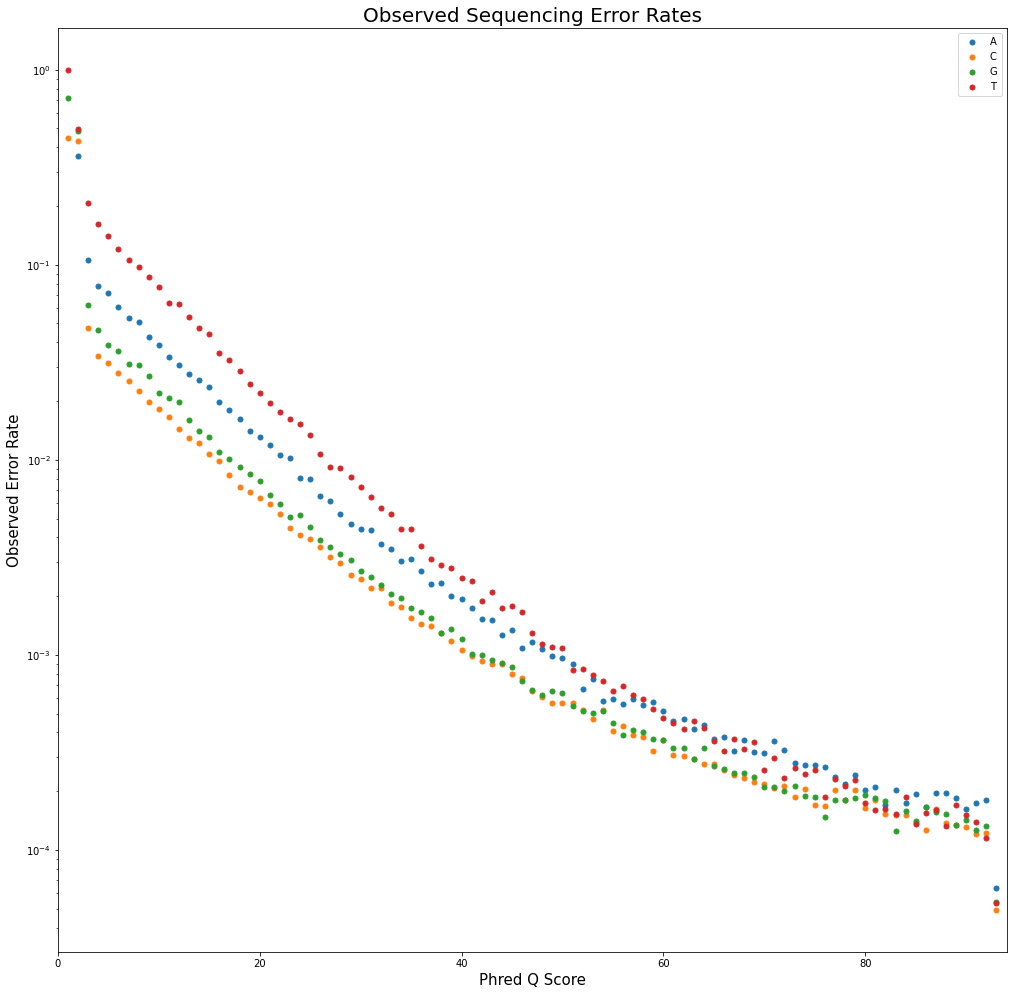

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
raw_x = [i for i in np.arange(33-33, 127-33)]
plt.figure(figsize=(17,17))

to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = snips[n]
    for i in focus.keys():
        stats = focus.get(i)
        total = np.sum(stats)
        wrong = np.sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y
    
    
for nuc in list(to_plot.keys()):
    focus = to_plot[nuc]
    for n, num in enumerate(focus):
        # focus[n] = 33 - (10 * np.log10(num)) # Gets the actual observed Q Score
        focus[n] = num # Use just percentage
        
for nuc in list(to_plot.keys()):
    plt.scatter(raw_x, to_plot[nuc], marker='.', s=100)
# plt.plot(raw_x, (pd.DataFrame(to_plot).mean(axis=1).values), color='k', label="mean")

# plt.plot(np.arange(33, 127), np.arange(33, 127), color='k')

plt.title('Observed Sequencing Error Rates', fontsize=20)
plt.xlabel('Phred Q Score', fontsize=15)
plt.ylabel('Observed Error Rate', fontsize=15)
plt.xlim([0, 94])
plt.legend(['A', 'C', 'G', 'T'])
plt.yscale('log')



### Bar Plots of Individual Sample Sizes (Nucleotide)

In [ ]:
def get_samplesize(tracking, nuc):
    sample_sizes = []
    focus = tracking[nuc]
    for q in focus.keys():
        if q == 126:
            sample_sizes.append(0)
            break
        sample_sizes.append(np.sum(focus[q]))
    return sample_sizes       

fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)


n = 0
nuc = {0: 'A', 1: 'C', 2 : 'G', 3: 'T'}
color = {0: 'blue', 1: 'gold', 2: 'green', 3: 'red'}
for i in range(2):
    for j in range(2):
      
        axs[i,j].barh(raw_x, get_samplesize(snips, nuc[n]), color=color[n])
        axs[i,j].set_title(f'Nucleotide {nuc[n]}')
        
        n +=1
# axs.set('Sample size (n) per Phred Q score per Nucleotide')



### Stacked Area Plot of Sample size differences
(Don't use)
- Shows how much each contribute to the cumulative total, but I care about highlighting the differences in individual area

In [ ]:
# plt.figure(figsize=(15, 15))
# plt.stackplot(raw_x,
#               [get_samplesize(snips, 'T'), get_samplesize(snips, 'A'), get_samplesize(snips, 'G'), get_samplesize(snips, 'C')],
#               labels=['T', 'A', 'G', 'C'],
#               colors=['red', 'blue', 'green', 'gold'],
#               alpha=0.8)
# plt.legend(loc=2, fontsize='large')
# plt.xlim([35, 125])
# plt.title('Sample Size by Q score per Nucleotide in SNPs', fontsize=20)
# plt.show()

### Area Plot


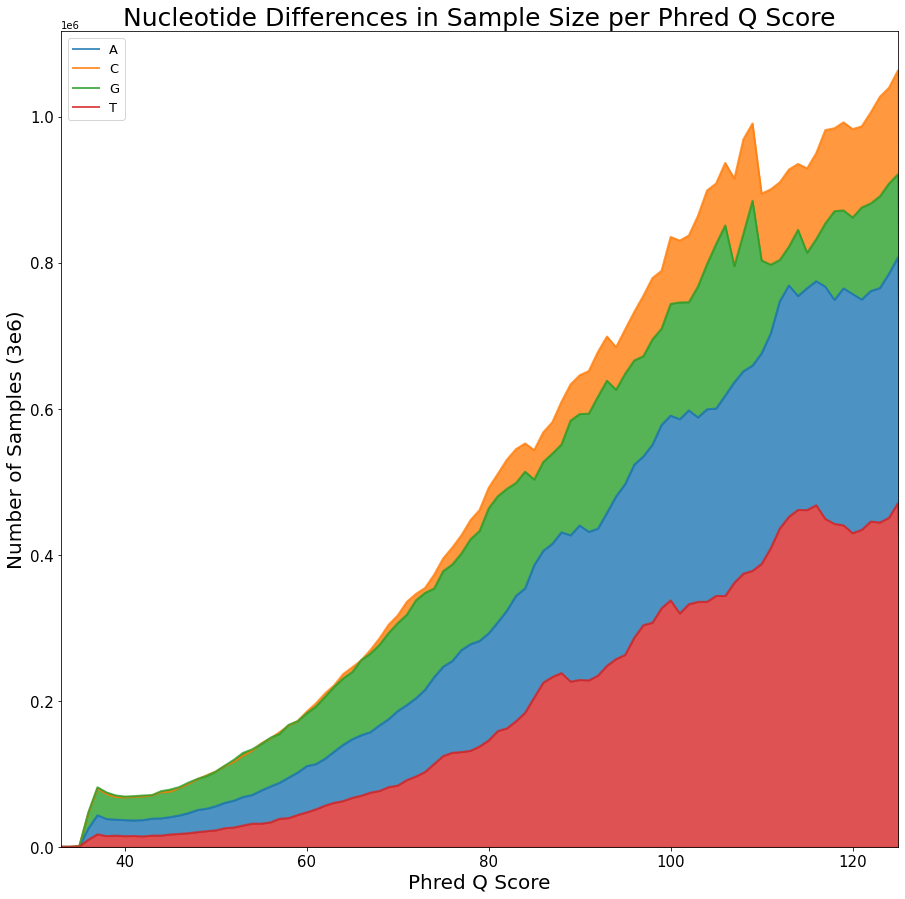

In [188]:
# //TODO: Plot the graph twice: one for indels tracking. one for snips tracking. 

# fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharex=True, sharey=True)
plt.figure(figsize=(15,15))


# Plot line graphs
for n in ['A', 'C', 'G', 'T']:
    plt.plot(raw_x, get_samplesize(snips, n), alpha=0.8, linewidth=2, label=n)
    
# Area Plot (customized)
plt.fill_between(raw_x, get_samplesize(snips, 'C'), get_samplesize(snips, 'G'), color='C1', alpha=0.8)
plt.fill_between(raw_x, get_samplesize(snips, 'G'), get_samplesize(snips, 'A'), color='C2', alpha=0.8)
plt.fill_between(raw_x, get_samplesize(snips, 'A'), get_samplesize(snips, 'T'), color='C0', alpha=0.8)
plt.fill_between(raw_x, 0, get_samplesize(snips, 'T'), color='C3', alpha=0.8)

# Properties
plt.legend(fontsize=13)
plt.xlim(33, 125)
plt.ylim(bottom=0)
plt.title('Nucleotide Differences in Sample Size per Phred Q Score', fontsize=25)
plt.xlabel('Phred Q Score', fontsize=20)
plt.ylabel('Number of Samples (3e6)', fontsize=20)
plt.tick_params(labelsize=15)

plt.show()

In [178]:
red_counter = dict(zip(['A', 'C', 'T', 'G'], [{i : [0,0] for i in np.arange(34, 127)}]*5))

for rfp in rfp_list:
    if rfp.empty: continue
    
    cov = int((len(rfp.columns)-4)/2)
    if cov > 4:
        for read_num in range(1, cov+1):
            read = rfp[f'read{read_num}']
            true = rfp.loc[:, 'contig']
            idx = truncate_start(read)
            end = truncate_end(read, idx)
            for nuc in range(idx, end):
                true_nuc = true.iloc[nuc]
                chr_tnuc = chr(true_nuc) # convert to a chr the targ
                qscore = rfp[f'q{read_num}'].iloc[nuc] # The qscore
                check = read.iloc[nuc] # 
                if qscore == 33:
                    # Time to test different ones.
                    continue
                
                if true_nuc != 45:
                    if true_nuc == check:
                        red_counter[chr_tnuc][qscore][0] += 1
                    else: 
                        red_counter[chr_tnuc][qscore][1] += 1
                    

In [ ]:
# import pickle
# with open('pickle/v3TrackingwRFP.pickle', 'wb') as f:
#     pickle.dump(tracking, f)

1

In [43]:
# A = pd.DataFrame(deletions['A'])
# C = pd.DataFrame(deletions['C'])
# G = pd.DataFrame(deletions['G'])
# T = pd.DataFrame(deletions['T'])
# df = A + C + G + T

Frequency of specific deletions. Assume order has no uniqueness

In [ ]:
import matplotlib.pyplot as plt
raw_x = np.arange(32, 127)
def plot_del_freq(A, nuc):
    Arec = A.sum(axis=1)
    total = Arec.sum()
    to_see = list(Arec.index)
    temp = list(Arec.index)

    to_see = Arec.index
    for i in temp:
        for j in to_see:
            if i == j: continue
            if (i == j[::-1]): 
                Arec[i] += Arec[j]
                Arec = Arec.drop(j)
                temp.remove(j)
                to_see.drop(j)
    plt.plot(Arec.index, Arec/total, label=nuc)
    return Arec

plot_del_freq(df, "total")
plot_del_freq(A, 'A')
plot_del_freq(C, 'C')
plot_del_freq(G, 'G')
plot_del_freq(T, 'T')
plt.legend(loc='best')



Assume ordering is unique.

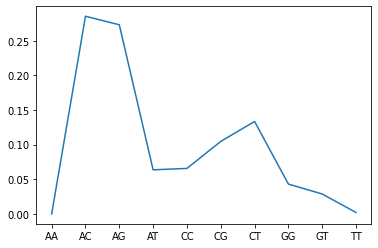

In [48]:
def plot_del_freq(A):
    Arec = A.sum(axis=1)
    total = Arec.sum()
    to_see = list(Arec.index)
    temp = list(Arec.index)

    to_see = Arec.index
    for i in temp:
        for j in to_see:
            if i == j: continue
            if (i == j[::-1]): 
                Arec[i] += Arec[j]
                Arec = Arec.drop(j)
                temp.remove(j)
                to_see.drop(j)
    plt.plot(Arec.index, Arec/total)


### Correcting Q Score

In [92]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : [], '-': []}


raw_x = [i for i in np.arange(33, 127)] #34 is 0 in test

to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : [], '-': []}
for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y

/tmp/ipykernel_1840435/1095344616.py:26: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AC)))
/tmp/ipykernel_1840435/1095344616.py:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AG)))
/tmp/ipykernel_1840435/1095344616.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AT)))
/tmp/ipykernel_1840435/1095344616.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.plot(test, list(map(np.log10, AI)))


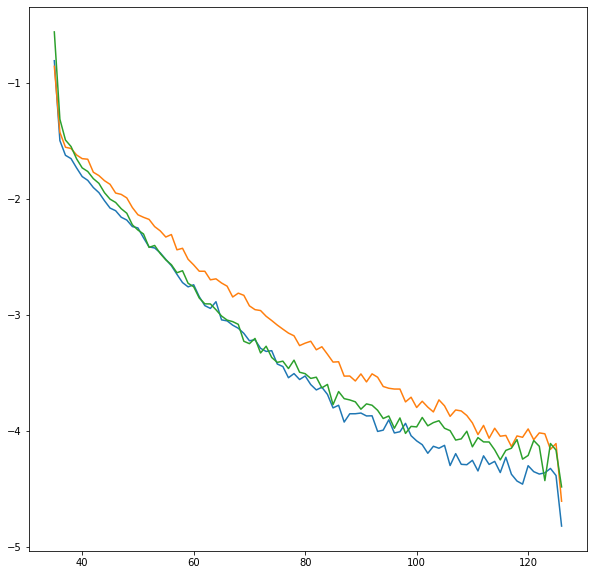

In [186]:
test = []
AT = []
AC = []
AG = []
AI = []

for q, freq in tracking['A'].items():
    test.append(q)
    total = freq[0]
    check = freq[2:]
    for idx, num in enumerate(check):
        if idx == 0:
            if total == 0: AC.append(0)
            else: AC.append(num/total)
        elif idx == 1:
            if total == 0: AG.append(0)
            else: AG.append(num/total)
        elif idx == 2:
            if total == 0: AT.append(0)
            else: AT.append(num/total)
        elif idx == 3:
            if total == 0: AI.append(0)
            else: AI.append(num/total)
        else: print(f"?{q} {idx} {num}")
plt.figure(figsize=(10,10))
plt.plot(test, list(map(np.log10, AC)))
plt.plot(test, list(map(np.log10, AG)))
plt.plot(test, list(map(np.log10, AT)))
plt.plot(test, list(map(np.log10, AI)))

    

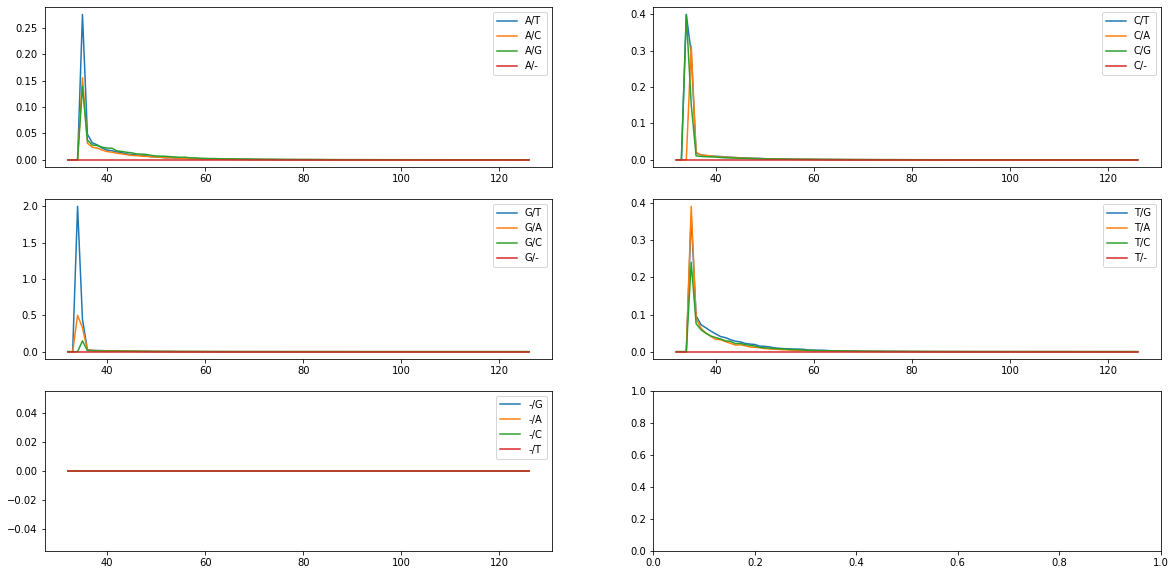

In [183]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
skip = {'A':0, 'C':1, 'G':2, 'T':3, '-':4}

for nuc in ['A', 'C', 'G', 'T', '-']:
    test = []
    AT = []
    AC = []
    AG = []
    AI = []

    for q, freq in tracking[nuc].items():
        test.append(q)
        total = freq[0]
        check = freq[1:]
        check.pop(skip[nuc])
        for idx, num in enumerate(check):
            if idx == 0:
                if total == 0: AC.append(0)
                else: AC.append(num/total)
            elif idx == 1:
                if total == 0: AG.append(0)
                else: AG.append(num/total)
            elif idx == 2:
                if total == 0: AT.append(0)
                else: AT.append(num/total)
            elif idx == 3:
                if total == 0: AI.append(0)
                else: AI.append(num/total)
            else: continue
    if nuc =='A':
        axes[0,0].plot(test, AT, label = 'A/T')
        axes[0,0].plot(test, AC, label = 'A/C')
        axes[0,0].plot(test, AG, label = 'A/G')
        axes[0,0].plot(test, AI, label = 'A/-')
        axes[0,0].legend()
    elif nuc =='C':
        axes[0,1].plot(test, AT, label = 'C/T')
        axes[0,1].plot(test, AC, label = 'C/A')
        axes[0,1].plot(test, AG, label = 'C/G')
        axes[0,1].plot(test, AI, label = 'C/-')
        axes[0,1].legend()
    elif nuc =='G':
        axes[1,0].plot(test, AT, label = 'G/T')
        axes[1,0].plot(test, AC, label = 'G/A')
        axes[1,0].plot(test, AG, label = 'G/C')
        axes[1,0].plot(test, AI, label = 'G/-')
        axes[1,0].legend()
    elif nuc == 'T':
        axes[1,1].plot(test, AT, label = 'T/G')
        axes[1,1].plot(test, AC, label = 'T/A')
        axes[1,1].plot(test, AG, label = 'T/C')
        axes[1,1].plot(test, AI, label = 'T/-')
        axes[1,1].legend()
    else:
        axes[2,0].plot(test, AT, label = '-/G')
        axes[2,0].plot(test, AC, label = '-/A')
        axes[2,0].plot(test, AG, label = '-/C')
        axes[2,0].plot(test, AI, label = '-/T')
        axes[2,0].legend()


In [6]:
tracking = pickle.load( open('pickle/v2TrackingwRFP.pickle', 'rb'))

### Plotting Nucleotide-specific Error Patterns

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
skip = {'A' : 0, 'C' : 1, 'G': 2, 'T': 3}
associate = {0 : 'A', 1: 'C', 2: 'G', 3: 'T'}

x = [i for i in np.arange(33, 126)]
for nuc in ['A']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 45: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'C', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:
x = [i for i in np.arange(39, 126)]
for nuc in ['C']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'G', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')
        plt.tight_layout()

In [ ]:

for nuc in ['G']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'T'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')  
        plt.tight_layout()

In [ ]:
for nuc in ['T']:
    ict = {'A' : [], 'C' : [], 'G' : [], 'T' : []} 
    for q, v in tracking[nuc].items():
        if q < 39: continue
        total = sum(v)
        nuc_misreads = v[1:-1]
        for idx, count in enumerate(nuc_misreads):
            if idx == skip[nuc]:
                continue
            ict[associate[idx]].append(count)
    for n in ['A', 'C', 'G', 'T']:
        curr = ict[n]
        if len(curr) < 2: continue
        plt.plot(x, curr[:-1])
        plt.legend(labels=[ 'A', 'C', 'G'])
        plt.ylabel('Error Count')
        plt.xlabel('Phred Quality Score')

### VISUALIZE: Real Error of z and yyy

#### Z Conflicts

- Currently: Plot total wrong / all instances of reads vs true
- Line of best fit plotted at Q > 45


In [248]:
# Let's start basic
# Just 'A' and total wrong
# Remember that 33 is useless. 32 does not exist.
to_plot = {'A' : [], 'C' : [], 'G' : [], 'T' : []}


raw_x = [i for i in np.arange(35, 127)] #34 is 0 in test

for n in ['A', 'C', 'G', 'T']:
    raw_y = []
    focus = tracking[n]
    for i in focus.keys():
        if i < 35: continue
        stats = focus.get(i)
        total = sum(stats)
        wrong = sum(stats[1:])
        if total == 0:
            raw_y.append(0)
        else: raw_y.append(wrong/total)
    to_plot[n] = raw_y




Take the log if non-zero. Motive: linear graph

In [254]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

for nuc in ['A', 'C', 'G', 'T']:
    to_change = to_plot[nuc]
    for i in range(len(to_change)):
        if to_change[i] == 0: 
            to_change[i] = 0 
        else: 
            to_change[i] = math.log(to_change[i])


Fill in missing values with a mean (only present at low sample sizes)

In [80]:
for nuc in ['A', 'C', 'G', 'T']:
    fix = to_plot[nuc]
    for i in range(len(fix)):
        if fix[i] == 0:
            fix[i] = 0.5*(fix[i-1]+fix[i+1])

Plot the 4 nucleotides 

In [ ]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,10))
plt.subplots_adjust(wspace=0,hspace=0)

axes[0,0].scatter(raw_x, to_plot['A'], c='red',s=12)
axes[0,1].scatter(raw_x, to_plot['C'], c='blue', s=12)
axes[1,0].scatter(raw_x, to_plot['G'], c='green',s=12)
axes[1,1].scatter(raw_x, to_plot['T'], c='purple',s=12)

# Needs to be calculated below
# axes[0,0].scatter(x, lobA, c='black')
# axes[0,1].scatter(x, lobC, c='black')
# axes[1,0].scatter(x, lobG, c='black')
# axes[1,1].scatter(x, lobT, c='black')

# # Check something...
# for i in range(2):
#     for j in range(2):
#         axes[i,j].hlines(0.01, 35, 126)

labels = ['A', 'C', 'G', 'T']
# labels_with_lobf = ['A', '_lobfA', 'C', '_lobfC',  'G', '_lobfG',  'T', '1e-2']
fig.legend(labels=labels, loc="right")
fig.suptitle('Associating Error Rate with Phred Q Score (n=455,157)', fontsize=25)
fig.supxlabel('Phred Q scores', fontsize=20)
fig.supylabel('Log_10 Adjusted Real Error Rate', fontsize=20)
# fig.supylabel('Real Error Rate', fontsize=20)





In [242]:
# count = 0
# for rfp in rfp_list:
#     if int((len(rfp.columns)-4)/2) > 3:
#         count += 1
# count

100053

### Line of best fits
- Calculated using ML and after Q = 45


In [94]:
# Assessing if contig is a viable thing to use for RFP Truth
for x,rfp in enumerate(rfp_list):
    if DNA_seqs.get_coverage_count(x+1) > 3:
        if rfp.empty: continue
        muts = rfp['changes']
        if len(muts[muts==122]) > 1:
            print(x+1)
            break

59


Using torch to calculate line of best fit

In [168]:
# Desired func y = mx + b => # params are m, b
import torch
p = torch.randn(2).requires_grad_()

In [169]:
x = torch.tensor(np.arange(46, 127)).long()
yA = torch.tensor(to_plot['A'][11:]).float()
yC = torch.tensor(to_plot['C'][11:]).float()
yG = torch.tensor(to_plot['G'][11:]).float()
yT = torch.tensor(to_plot['T'][11:]).float()

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x,self.y = x,y
        self.len = len(x)
        
    def __len__(self): return self.len
    
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

testdsA = torch.utils.data.DataLoader(Dataset(x,yA), batch_size=3)
testdsC = torch.utils.data.DataLoader(Dataset(x,yC), batch_size=5)
testdsG = torch.utils.data.DataLoader(Dataset(x,yG), batch_size=5)
testdsT = torch.utils.data.DataLoader(Dataset(x,yT), batch_size=5)

In [ ]:
def func(params, input):
    a, b = params
    return a*input + b

import torch.functional as F
from fastai.vision.all import *
from fastbook import *

def loss_func(pred, targ):
    # Let's use RMSE
    return ((pred-targ)**2).sqrt()

lr = 1e-5
for i in range(1000):
    loss_total = 0
    n_obs = 0
    for xin, yin in testdsT:
        
        pred = func(p, xin)
        loss = loss_func(pred, yin).mean()
        
        loss.backward() 
        p.data -= p.grad.data * lr
        p.grad = None
        
        n = len(xin)
        loss_total += loss.item()*n
        n_obs +=n
        
    print(loss_total/n_obs)

In [178]:
def f(x):
    a,b =p.data
    return a*x+b

In [183]:
lobT = []
for i in x:
    lobT.append(f(i))

#### YYY Conflicts

- Two main categories:
    - Insertion (Target, non-agreeing reads have '-' for alignment)
    - Deletion  (Only read has '-' for alignment) 

&nbsp;


- Insertion types:
    - Misaligned multi-insertions 
        - e.g. aligned as G-GG-AG / G**G**G*A*GAG when it should be GGG--AG / GGG**AG**AG) 
    - Multi-insertions (G--G / GAAG)
        - [4y+]
    - **Harmonious** Insert
        - Matches left AND right
    - **1x Discord** Insert
        - Matches left OR right nuc
    - **2x Discord** Insert
        - No match with left OR right
<br>      
&nbsp;
- Deletion types: (Note: the thing that *matches* is the truth that was deleted)
    - **Harmonious** del
        - Matches left AND right nuc
    - **1X Discord** del 
        - Matches left OR right nuc 
    - **2x Discord** del 
        - No match with left OR right [e.g. A-G when others say A**C**G]

Checking Difference in Error Counts between Nucleotides
- Not shown: spikes at Q=126
    - A ~ 20,000; C,G ~ 18,000; T ~ 10,000

In [ ]:
tracking_vocab = ['correct', 'A', 'C', 'G', 'T', '-']
tracking['A']

for nuc in ['A', 'C', 'G', 'T']:
    error_frequency = []
    for q, v in tracking[nuc].items():
        if q > 34:
            error_frequency.append(sum(v[1:]))
    q_related = [x for x in np.arange(35, 126)]
    plt.plot(q_related, error_frequency[:-1])
    # print(np.argmax(error_frequency[:-1]), max(error_frequency[:-1]))
    # print(error_frequency[2])
plt.legend(labels=['A', 'C', 'G', 'T'])
plt.ylabel('Error Count')
plt.xlabel('Phred Quality Score')
    # max_freq = max(error_frequency[:-1])
    # norm = [item/max_freq for item in error_frequency[:-1]]
    # plt.plot(q_related, norm)
    # plt.text(126, error_frequency[-1]-20_000, "%d" %error_frequency[-1] + nuc, ha="right")

&nbsp;

**Resolution**
- No Q score difference:
    - (! is an insert) \~\~\~ vs. ~!~ => \~\~\~ wins
